In [147]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rliable import metrics
from rliable import library as rly
from crl.utils.graphing import despine
from pathlib import Path
from dataclasses import dataclass
from copy import deepcopy

In [171]:
results_dir = Path("..", "..", "results").resolve()
output_dir = results_dir / "figures"

In [172]:
# CartPole    >  490
# Acrobot     > -100
# MountainCar > -110
# Pendulum    > -200

In [173]:
@dataclass
class EnvInfo:
    filename: str
    agent_result_names: dict[str, str]
    param: str
    nominal_val: float
    reward_threshold: int
    min_return: int
    preferred_alg: str | None = None

In [174]:
#  global config options
cartpole_info = EnvInfo(
    filename="cartpole",
    agent_result_names={
        "cql_final": "CQL-DQN",
        "ddqn_final": "DDQN",
        "alpha_exp_0-01": 'DQN-Disc',
        "cartpole_lr_1e3": "DQN-NN",
    },
    param="length",
    nominal_val=0.5,
    reward_threshold=490,
    min_return=0,
)

mountaincar_info = EnvInfo(
    filename="mountaincar",
    agent_result_names={
        "cqldqn": "CQL-DQN",
        "ddqn_final": "DDQN",
        "dqn_final": "DQN-NN",
        "mc_alpha_0-05": "DQN-Disc",
    },
    param="gravity",
    nominal_val=0.0025,
    reward_threshold=-200,
    min_return=-210,
)

acrobot_info = EnvInfo(
    filename="acrobot",
    agent_result_names={
        "cql": "CQL-DQN",
        "ddqn": "DDQN",
        "vanilla": "DQN",
    },
    param="LINK_LENGTH_1",
    nominal_val=1.0,
    reward_threshold=-100,
    min_return=-210,
)

lunarlander_info = EnvInfo(
    filename="lunarlander",
    agent_result_names={},
    param="gravity",
    nominal_val=-10.0,
    reward_threshold=200,
    min_return=0,
)

CFG = acrobot_info

In [175]:
from functools import cache

def maybe_get_value(run, key, i):
    try:
        returns = run[key][i]
    except KeyError:
        returns = None
    return returns

@cache
def load_data(fp: str, param: str = "length"):
    data = pd.read_pickle(fp)

    df_data = []
    # the data contains runs for a seed - each seed has 20 experiments with different
    # lengths - and at each length there are 250 evaluations - so need to unnest and
    # extract the relevant info.
    for exp in data:
        seed = exp["seed"]
        results = exp["results"]
        for run in results:
            length = run[param]
            for i in range(250):
                returns_conf = maybe_get_value(run, 'returns_conf', i)
                returns_ccnn = maybe_get_value(run, 'returns_ccnn', i)
                returns_noconf = maybe_get_value(run, 'returns_noconf', i)
                run_info = {
                    "seed": seed,
                    "run": i,
                    param: length,
                    "returns_noconf": returns_noconf,
                    "returns_conf": returns_conf,
                    "returns_ccnn": returns_ccnn,
                }
                returns_tta = maybe_get_value(run, 'returns_tta', i)
                if returns_tta is not None:
                    run_info.update({'returns_tta': returns_tta})
                df_data.append(run_info)

    return pd.DataFrame(df_data)

In [176]:
# Cartpole results
def load_dataframes(config: EnvInfo = CFG):
    env_dir = results_dir / config.filename
    dfs = []
    for agent_type, label in config.agent_result_names.items():
        fp = env_dir / agent_type / "robustness_experiment.pkl"
        df = load_data(fp, param=config.param)
        df["agent_type"] = label
        dfs.append(df)
    df = pd.concat(dfs)
    df[config.param] = df[config.param].round(
        4
    )  # fp error causes indexing issues later on
    # [
    #     print(s, df[s].mean().round(2))
    #     for s in ["returns_conf", "returns_noconf", "returns_ccnn"]
    # ]
    return df


df = load_dataframes(CFG)

In [177]:
# if evaluating cartpole, filter out the 0.1 alpha for CC-Disc, and the 0.05 alpha for CC-NN
if CFG.filename in ['cartpole', 'mountaincar']:
    dqn_disc = df[df['agent_type']=='DQN-NN']
    dqn_disc = dqn_disc.drop(columns='returns_conf')
    dqn_nn   = df[df['agent_type']=='DQN-Disc'][['seed','run', CFG.param, 'returns_conf']]

    # merge on the keys that identify rows
    new_df = dqn_disc.merge(dqn_nn, on=['seed','run', CFG.param], how='left')
    new_df['agent_type'] = 'DQN'

    df = df[~df['agent_type'].isin(['DQN-Disc','DQN-NN'])].copy()
    df = pd.concat([new_df, df], ignore_index=True)

In [178]:
cmap = {
    "returns_conf": "tab:blue",
    "returns_ccnn": "tab:green",
    "returns_noconf": "tab:orange",
}
label_names = {
    "returns_conf": "CC-DISC",
    "returns_ccnn": "CC-NN",
    "returns_noconf": "Uncalibrated",
}


def filter_df(
    df: pd.DataFrame,
    config: EnvInfo,
    aggfunc: dict[str, str] = {
        "returns_noconf": "mean",
        "returns_ccnn": "mean",
        "returns_conf": "mean",
    },
):
    df_agg = df.groupby(["agent_type", "seed", config.param]).aggregate(aggfunc)

    idx = pd.IndexSlice
    bad_seeds = (
        df_agg.loc[idx[:, :, config.nominal_val]] < config.reward_threshold
    ).all(axis=1)
    good_pairs = bad_seeds.index[~bad_seeds.values]

    # 3) Select ALL rows (all param values) in the original df for those good pairs
    df_sorted = df_agg.sort_index()
    mask = df_sorted.index.droplevel(config.param).isin(
        good_pairs
    )  # drop 3rd level, test membership
    df_good: pd.DataFrame = df_sorted[mask]
    return df_good


def plot_robustness_experiment(
    df: pd.DataFrame,
    title: str,
    config: EnvInfo,
    xlim: tuple = (None, None),
    ylim: tuple = (None, None),
):
    aggfunc = {
        "returns_noconf": "mean",
        "returns_conf": "mean",
        "returns_ccnn": "mean",
    }

    df_good = filter_df(df, config, aggfunc)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    # disable per-axis legends

    df_good.loc["DQN"].groupby(config.param).median().plot(
        marker="o", title="DQN", ax=axes[0], legend=False, color=cmap
    )
    df_good.loc["DDQN"].groupby(config.param).median().plot(
        marker="o", title="DDQN", ax=axes[1], legend=False, color=cmap
    )
    df_good.loc["CQL-DQN"].groupby(config.param).median().plot(
        marker="o", title="CQL-DQN", ax=axes[2], legend=False, color=cmap
    )

    for ax in axes:
        despine(ax)
        ax.grid(linestyle="--", alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axvline(
            config.nominal_val, linestyle="--", c="k", alpha=0.5, linewidth=1, zorder=-5
        )

    # collect unique handles/labels from all axes (preserve order)

    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        l = [label_names[lab] for lab in l]
        for hi, li in zip(h, l):
            if li not in labels:
                handles.append(hi)
                labels.append(li)

    # room for the legend under the figure
    fig.subplots_adjust(bottom=0.22, top=0.82)

    # single legend below the figure laid out as a row
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), frameon=False)

    fig.suptitle(title)
    output_path = (
        output_dir / "robustness_experiments" / f"{config.filename}_robustness.pdf"
    )
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()
    return df_good

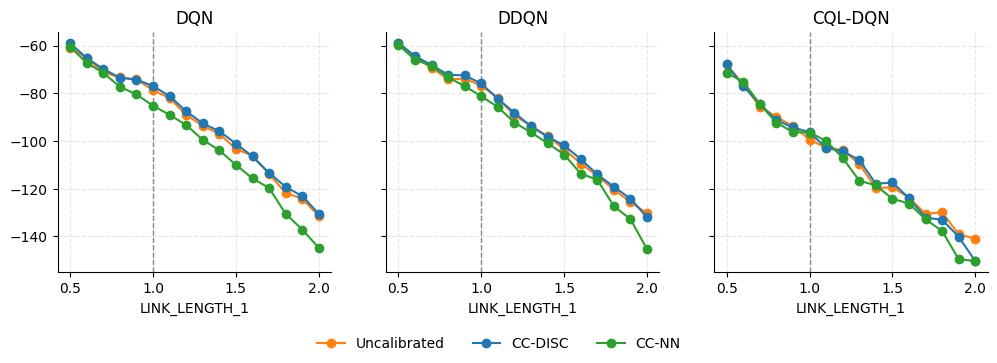

In [179]:
df_filtered = plot_robustness_experiment(
    df=df,
    config=CFG,
    title="",
)
df_filtered = df_filtered.reset_index()

In [180]:
def iqm(scores):
    return np.array(
        [
            metrics.aggregate_iqm(scores[..., length])
            for length in range(scores.shape[-1])
        ]
    )


def compute_ratios(df: pd.DataFrame, config: EnvInfo, numerator: str = "returns_conf"):
    df["ratio"] = (df[numerator] - config.min_return) / (
        df["returns_noconf"] - config.min_return
    )
    param_vals = df[config.param].unique()
    ratio = (
        df.pivot(index="seed", columns=config.param, values="ratio")
        .to_numpy()
        .reshape(-1, 1, len(param_vals))
    )
    return ratio


agent_type = "DQN"
agent_df = df_filtered[df_filtered["agent_type"] == agent_type].copy()
param_vals = agent_df[CFG.param].unique()

ratio_disc = compute_ratios(agent_df, CFG, "returns_conf")
ratio_ccnn = compute_ratios(agent_df, CFG, "returns_ccnn")
ratio_dict = {"CC-Disc": ratio_disc, "CC-NN": ratio_ccnn}

ratio_score, ratio_cis = rly.get_interval_estimates(ratio_dict, iqm, reps=50_000)

CC-Disc Mean Improvement: 1.005x (0.994x - 1.017x)
CC-NN Mean Improvement: 0.943x (0.907x - 0.976x)


/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_1034/845011514.py:56: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28)


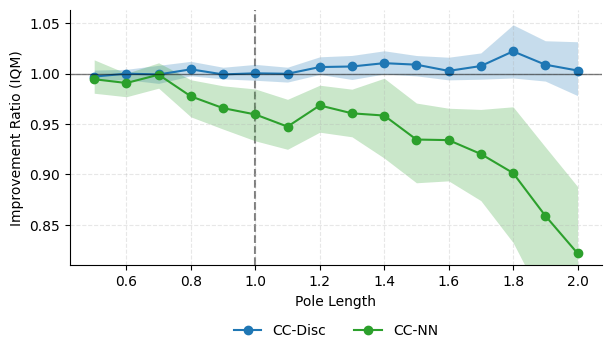

In [ ]:
def plot_improvement_curve(
    xs,
    ratio_score,
    ratio_cis,
    title: str,
    xlabel: str,
    config: EnvInfo,
    legend_title: str | None = None,
    ylim: tuple[float] = (0.75, 2.5),
    xlim: tuple[float] = (None, None),
    plotname: str | None = None,
    figsize: tuple[float, float] = (6, 3.5)
):
    fig, ax = plt.subplots(
        figsize=figsize, layout="constrained"
    )  # or constrained_layout=True
    for algo in ratio_score:
        iqms = ratio_score[algo]
        lower, upper = ratio_cis[algo]
        match algo:
            case "CC-Disc":
                colour = "tab:blue"
            case "CC-NN":
                colour = "tab:green"
            case r'$|\hat{y} - y_\text{true}|$':
                colour = 'tab:orange'
            case "CC-Disc (test-time)":
                colour = 'tab:red'
            case _:
                colour = None
        ax.plot(xs, iqms, marker="o", label=algo, c=colour)
        ax.fill_between(xs, lower, upper, alpha=0.25, color=colour, linewidth=0)

        print(
            f"{algo} Mean Improvement: {iqms.mean():.3f}x ({lower.mean():.3f}x - {upper.mean():.3f}x)"
        )
    ax.axhline(1.0, c="k", alpha=0.5, linewidth=1)
    despine(ax)
    ax.grid(alpha=0.3, linestyle="--")
    ax.axvline(config.nominal_val, linestyle="--", color="k", zorder=0, alpha=0.5)
    ax.set_ylabel("Improvement Ratio (IQM)")
    ax.set_xlabel(xlabel)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    fig.suptitle(title)
    if legend_title is not None:
        ncols = max(1, len(ratio_score))
        ax.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.18),  # center below the axes
            ncol=ncols,
            title=legend_title,
        )
        # make room for the legend
        fig.subplots_adjust(bottom=0.28)

    plotname = plotname or config.filename

    output_path = output_dir / "robustness_experiments" / f"{plotname}_ratio.pdf"
    plt.savefig(output_path)
    plt.show()


plot_improvement_curve(
    param_vals,
    ratio_score,
    ratio_cis,
    title="",
    xlabel="Pole Length",
    config=CFG,
    legend_title="",
    xlim=(None, None),
    ylim=(0.81, 2.5),
)

In [182]:
# mean improvement of CQL


### Plot seeds

valid seeds [ 1  3  4  5  6  7  9 12 14 15 17 21 22 24]


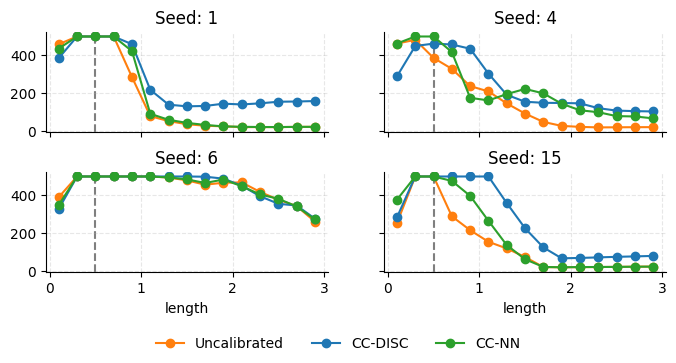

In [ ]:
# plot seeds on a grid
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
seeds_df = df_filtered[df_filtered["agent_type"] == "DQN"]
print("valid seeds", seeds_df["seed"].unique())
cols = ["returns_noconf", "returns_conf", "returns_ccnn"]
for ix, s in enumerate([1, 4, 6, 15]):
    plot_df = seeds_df[seeds_df["seed"] == s].set_index(CFG.param)[cols]
    ax = axes[ix // 2, (ix % 2)]
    plot_df.plot(marker="o", ax=ax, legend=False, color=cmap)
    ax.axvline(CFG.nominal_val, linestyle="--", color="k", zorder=0, alpha=0.5)
    despine(ax)
    ax.grid(alpha=0.3, linestyle="--")
    ax.set_title(f'Seed: {s}')

# axes[0, 0].set_xlim(0, None)
# axes[0, 0].set_ylim(0, None)

handles, labels = [], []
h, l = ax.get_legend_handles_labels()
l = [label_names[lab] for lab in l]
for hi, li in zip(h, l):
    if li not in labels:
        handles.append(hi)
        labels.append(li)

# room for the legend under the figure
fig.subplots_adjust(bottom=0.22, top=0.82, hspace=0.4)

# single legend below the figure laid out as a row
fig.legend(handles, labels, loc="lower center", ncol=len(labels), frameon=False)
output_path = output_dir / "robustness_experiments" / f"{CFG.filename}_seeds.pdf"
plt.savefig(output_path, bbox_inches="tight")
plt.show()

## CC-NN lunar lander

In [ ]:
results_dir = Path("..", "..", "results").resolve()
fp = (
    results_dir
    / "lunarlander"
    / "nn_10k_calib_k50"
    / "kernel_results_LunarLander-v3.pkl"
)

param = "gravity"
param_vals = np.arange(-12, -0, 0.5)
min_return = 0
nominal_val = -10
reward_threshold = 200

data = pd.read_pickle(fp)
df_data = []
for exp in data:
    seed = exp["seed"]
    noconf_returns = exp["noconf_returns"]
    ccnn_returns = exp["conf_returns"]
    for run in range(100):  # num runs
        for param_ix, param_val in enumerate(param_vals):
            run_info = {
                "seed": seed,
                "run": run,
                "gravity": param_val,
                "returns_noconf": noconf_returns[param_ix, run],
                "returns_ccnn": ccnn_returns[param_ix, run],
            }
            df_data.append(run_info)

In [ ]:
# filter the lunar lander df for null results
ll_df = pd.DataFrame(df_data)
agent_type = "DQN"
ll_df["agent_type"] = agent_type

CC-NN Mean Improvement: 1.108x (0.834x - 1.754x)


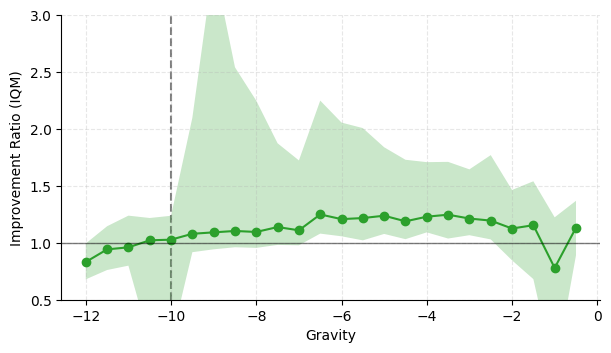

In [ ]:
aggfunc = {"returns_noconf": "mean", "returns_ccnn": "mean"}
df_good = filter_df(ll_df, lunarlander_info, aggfunc).reset_index()
agent_df = df_good[df_good['agent_type'] == agent_type]

ratio_disc = compute_ratios(agent_df, lunarlander_info, 'returns_ccnn')
ratio_dict = {'CC-NN': ratio_disc}

ratio_score, ratio_cis = rly.get_interval_estimates(
    ratio_dict, iqm, reps=50_000
)

plot_improvement_curve(
    param_vals,
    ratio_score,
    ratio_cis,
    title="",
    xlabel="Gravity",
    config=lunarlander_info,
    ylim=(0.5, 3.0),
)

## Combo Acrobot and MountainCar plots

## TD vs Monte Carlo

In [ ]:
acro_cfg = deepcopy(acrobot_info)
acro_cfg.agent_result_names = {"acro_montecarlo": "MC", "vanilla": "TD"}
acro_cfg.preferred_alg = "CC-Disc"

mcar_cfg = deepcopy(mountaincar_info)
mcar_cfg.agent_result_names = {"mc_alpha_0-01_montecarlo": "MC", "mc_alpha_0-01": "TD"}
mcar_cfg.preferred_alg = "CC-Disc"

cart_cfg = deepcopy(cartpole_info)
cart_cfg.agent_result_names = {"cartpole_mc2": "MC", "alpha_exp_0-01": "TD"}
cart_cfg.preferred_alg = "CC-Disc"

lunar_cfg = deepcopy(lunarlander_info)
lunar_cfg.agent_result_names = {"lunarlander_montecarlo": "MC", "ll_td": "TD"}
lunar_cfg.preferred_alg = "CC-NN"

acro_df = load_dataframes(acro_cfg)
mcar_df = load_dataframes(mcar_cfg)
cart_df = load_dataframes(cart_cfg)
lunar_df = load_dataframes(lunar_cfg)


returns_conf -111.74
returns_noconf -110.06
returns_ccnn -144.77
returns_conf -149.49
returns_noconf -150.85
returns_ccnn -150.76
returns_conf 233.21
returns_noconf 194.98
returns_ccnn 201.18
returns_conf 101.22
returns_noconf 103.49
returns_ccnn 93.76


In [ ]:
# ---- env inputs (your existing vars) ----
envs = [
    ("Acro", acro_df, acro_cfg),
    ("Mcar", mcar_df, mcar_cfg),
    ("Cart", cart_df, cart_cfg),
    ('Lunar', lunar_df, lunar_cfg)
]

# TODO: recollect cartpole with MC to see if it's consistently good
# ---- collect means and CIs per (env, agent_type) ----
rows = []
for agent_type in ["MC", "TD"]:
    for env_label, df, cfg in envs:
        alg = cfg.preferred_alg
        numerator = "returns_conf" if alg == "CC-Disc" else "returns_ccnn"
        df_filtered = filter_df(df, cfg).reset_index()
        agent_df = df_filtered[df_filtered["agent_type"] == agent_type].copy()

        ratio_disc = compute_ratios(agent_df, cfg, numerator)
        ratio_dict = {alg: ratio_disc}

        ratio_score, ratio_cis = rly.get_interval_estimates(
            ratio_dict, iqm, reps=50_000
        )

        mean = ratio_score[alg].mean()
        lower = ratio_cis[alg][0].mean()
        upper = ratio_cis[alg][1].mean()
        rows.append(
            {
                "env": env_label,
                "agent_type": agent_type,
                "mean": mean,
                "lower": lower,
                "upper": upper,
            }
        )

        print(f"Done: {env_label}, {agent_type} ({alg})")

Done: Acro, MC (CC-Disc)
Done: Mcar, MC (CC-Disc)
Done: Cart, MC (CC-Disc)
Done: Lunar, MC (CC-NN)
Done: Acro, TD (CC-Disc)
Done: Mcar, TD (CC-Disc)
Done: Cart, TD (CC-Disc)
Done: Lunar, TD (CC-NN)


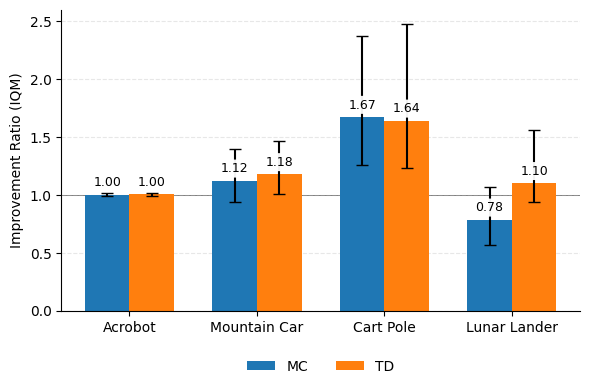

In [ ]:
res = pd.DataFrame(rows)

# ensure env order Acro, Mcar, Cart
res["env"] = pd.Categorical(
    res["env"], categories=["Acro", "Mcar", "Cart", "Lunar"], ordered=True
)
res = res.sort_values(["env", "agent_type"])


# pivot to arrays for plotting
def get_series(df, agent_type):
    d = df[df["agent_type"] == agent_type]
    m = d["mean"].to_numpy()
    lo = d["lower"].to_numpy()
    up = d["upper"].to_numpy()
    # asymmetric error bars: distances from mean to bounds
    yerr = np.vstack([m - lo, up - m])
    return m, yerr


means_mc, yerr_mc = get_series(res, "MC")
means_td, yerr_td = get_series(res, "TD")

x = np.arange(4)  # 3 env groups
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width / 2, means_mc, width, label="MC", yerr=yerr_mc, capsize=4)
ax.bar(x + width / 2, means_td, width, label="TD", yerr=yerr_td, capsize=4)

ax.set_xticks(x)
ax.set_xticklabels(["Acrobot", "Mountain Car", "Cart Pole", "Lunar Lander"])
ax.set_ylabel(f"Improvement Ratio (IQM)")
# ax.set_title("CC Ratio by Env and Agent Type")
# place legend below the plot (centered)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

for xpos, m in zip(x - width / 2, means_mc):
    ax.text(
        xpos, m+0.05, f"{m:.2f}",
        ha="center", va="bottom", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.95),
        zorder=10, clip_on=False
    )

for xpos, m in zip(x + width / 2, means_td):
    ax.text(
        xpos, m+0.05, f"{m:.2f}",
        ha="center", va="bottom", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.95),
        zorder=10, clip_on=False
    )

ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='--', alpha=0.3)
ax.axhline(1.0, c='k', zorder=-10, linewidth=0.5, alpha=0.7)
despine(ax)

plt.tight_layout()
plt.savefig(output_dir / 'mc_vs_td' / 'mc_td_comparison.pdf', bbox_inches='tight')
plt.show()

## Impact of $\alpha$

In [ ]:
alpha_vals = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99]
config = deepcopy(cartpole_info)

def stringify(alpha):
    return str(alpha).replace(".", "-")

config.agent_result_names = {f"alpha_exp_{stringify(a)}": str(a) for a in alpha_vals}
alpha_df = load_dataframes(config)

returns_conf 215.6
returns_noconf 195.06
returns_ccnn 200.33


In [ ]:
alg = "CC-NN"
alpha_rows = []
for alpha in alpha_vals:
    df_filtered = filter_df(alpha_df, config).reset_index()
    single_df = df_filtered[df_filtered["agent_type"] == str(alpha)].copy()

    ratio_disc = compute_ratios(single_df, config, "returns_conf")
    ratio_dict = {alg: ratio_disc}

    ratio_score, ratio_cis = rly.get_interval_estimates(ratio_dict, iqm, reps=50_000)

    mean = ratio_score[alg].mean()
    lower = ratio_cis[alg][0].mean()
    upper = ratio_cis[alg][1].mean()
    alpha_rows.append({"alpha": alpha, "mean": mean, "lower": lower, "upper": upper})

    print(f"Done: {alpha}")

alpha_res = pd.DataFrame(alpha_rows)

Done: 0.005
Done: 0.01
Done: 0.05
Done: 0.1
Done: 0.2
Done: 0.5
Done: 0.8
Done: 0.9
Done: 0.95
Done: 0.99


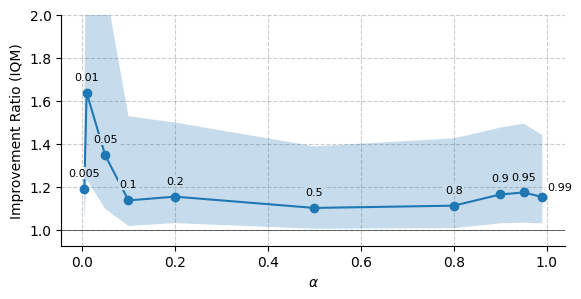

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox

alpha_res['alpha'] = pd.to_numeric(alpha_res['alpha'])

fig, ax = plt.subplots(figsize=(6.5, 3))

# Explicit zorders: line < blockouts < fill < text
(line,) = ax.plot(alpha_vals, alpha_res['mean'], marker='o', zorder=2)
ax.axhline(1.0, linewidth=0.5, c='k', alpha=0.8, zorder=1.5)
ax.fill_between(alpha_vals, alpha_res['lower'], alpha_res['upper'], alpha=0.25, zorder=2.5)

ax.grid(linestyle='--', c='k', alpha=0.2)
ax.set_ylim(None, 2.0)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Improvement Ratio (IQM)')
despine(ax)

# 1) Add transparent text first (no bbox), on top of everything
# texts = []
# for x, y in zip(alpha_vals, alpha_res['mean']):
#     # adjust dy if needed
#     texts.append(ax.text(x, y + 0.05, f"{x}", ha='center', va='bottom', fontsize=8, zorder=3))
texts = []
for i, (x, y) in enumerate(zip(alpha_vals, alpha_res['mean'])):
    if i == len(alpha_vals) - 1:  # last point
        texts.append(
            ax.text(
                x + 0.01,  # shift to the right
                y + 0.02,
                f"{x}",
                ha='left', va='bottom', fontsize=8, zorder=3
            )
        )
    else:
        texts.append(
            ax.text(
                x,
                y + 0.05,
                f"{x}",
                ha='center', va='bottom', fontsize=8, zorder=3
            )
        )

# 2) Force a draw so text sizes are known
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# 3) For each text, add a white rectangle underneath the fill but above the line
for t in texts:
    # Get text bbox in display (pixel) coords and pad slightly
    bb_disp = t.get_window_extent(renderer=renderer).expanded(1.15, 1.15)

    # Convert bbox corners to data coordinates
    (x0, y0), (x1, y1) = ax.transData.inverted().transform(bb_disp.get_points())

    # White blockout rectangle
    rect = mpatches.Rectangle(
        (x0, y0),
        width=(x1 - x0),
        height=(y1 - y0),
        facecolor='white',
        edgecolor='none',
        zorder=2.1,      # above line, below fill
        clip_on=True     # keep within axes
    )
    ax.add_patch(rect)

plt.savefig(output_dir / 'alpha' / 'alpha_cartpole.pdf', bbox_inches='tight')
plt.show()

## Overhead Comparison

In [ ]:
import yaml

In [ ]:
with open(results_dir / 'inference_overhead' / 'inference_overhead_all_envs.yaml', 'r') as f:
    inf_res = yaml.safe_load(f)
summary = inf_res['summary']

In [ ]:
methods = ['baseline_dqn', 'disc_cp', 'ccnn_cp']
envs = ['MountainCar-v0','CartPole-v1', 'Acrobot-v1', 'LunarLander-v3']
method_names = {'baseline_dqn': 'DQN',
                'disc_cp': 'CC-Disc',
                'ccnn_cp': 'CC-NN'}
colours = {'baseline_dqn': 'tab:orange',
                'disc_cp': 'tab:blue',
                'ccnn_cp': 'tab:green'}
env_names = {
    'CartPole-v1': 'Cart Pole\n4D',
    'MountainCar-v0': 'Mountain Car\n2D',
    'Acrobot-v1': 'Acrobot\n6D',
    'LunarLander-v3': 'Lunar Lander\n8D'
}

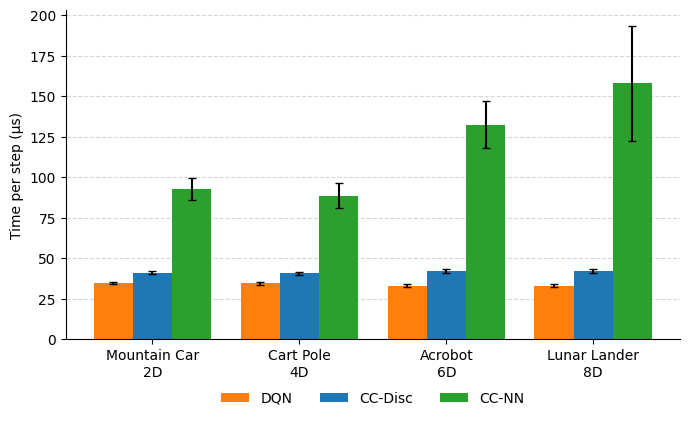

In [ ]:
x = np.arange(len(envs))
n_methods = len(methods)
width = 0.8 / n_methods  # total group width ~0.8

fig, ax = plt.subplots(figsize=(7, 4))

for i, method in enumerate(methods):
    means = [summary[env][method]['mean_us'] for env in envs]
    stds  = [summary[env][method]['std_us']  for env in envs]
    offset = (i - (n_methods - 1) / 2) * width
    ax.bar(x + offset, means, width, label=method_names[method], yerr=stds, capsize=3, color=colours[method])

ax.set_xticks(x)
ax.set_xticklabels([env_names[e] for e in envs])
ax.set_ylabel('Time per step (µs)')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(frameon=False)
ax.set_axisbelow(True)
fig.tight_layout()
despine(ax)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=False)
plt.savefig(output_dir / 'inference_overhead' / 'inference_overhead.pdf', bbox_inches='tight')
plt.show()

In [ ]:
for m in methods:
    # for e in envs:
    medians = [summary[e][m]['median_us'] for e in envs]
    print(f'{m}: {np.mean(medians)} ({medians})')

baseline_dqn: 33.8125 ([34.666, 34.542, 33.083, 32.959])
disc_cp: 41.375 ([40.875, 40.625, 42.041, 41.959])
ccnn_cp: 118.38575 ([93.292, 87.875, 134.084, 158.292])


## Score function comparison

In [ ]:
fp_signed = results_dir / 'cartpole' / 'CartPole_signed_score'
fp_unsigned = results_dir / 'cartpole' / 'CartPole_unsigned_score'

In [ ]:
cart_cfg = deepcopy(cartpole_info)
cart_cfg.agent_result_names = {"Cartpole_signed_score": "signed", "Cartpole_unsigned_score": "unsigned"}
cart_cfg.preferred_alg = "CC-Disc"
score_fn_df = load_dataframes(cart_cfg)

returns_conf 228.75
returns_noconf 194.74
returns_ccnn 199.01


In [ ]:
df_good = filter_df(score_fn_df, cart_cfg).reset_index()

agent_df = df_good[df_good['agent_type'] == 'signed'].copy()
ratio_signed = compute_ratios(agent_df, cart_cfg, 'returns_conf')
agent_df = df_good[df_good['agent_type'] == 'unsigned'].copy()
ratio_unsigned = compute_ratios(agent_df, cart_cfg, 'returns_conf')
ratio_dict = {r'$\hat{y} - y_\text{true}$': ratio_signed, r'$|\hat{y} - y_\text{true}|$': ratio_unsigned}

ratio_score, ratio_cis = rly.get_interval_estimates(
    ratio_dict, iqm, reps=50_000
)
param_vals = agent_df['length'].unique()

$\hat{y} - y_\text{true}$ Mean Improvement: 1.599x (1.189x - 2.550x)
$|\hat{y} - y_\text{true}|$ Mean Improvement: 1.389x (1.072x - 2.146x)


/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_54995/4142078780.py:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28)


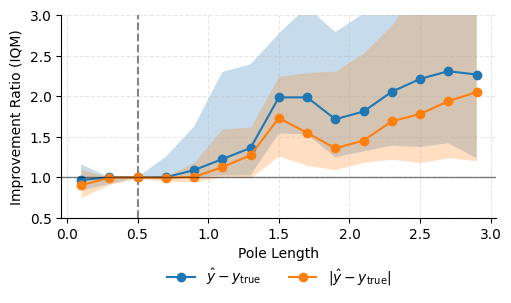

In [ ]:
plot_improvement_curve(
    param_vals,
    ratio_score,
    ratio_cis,
    title="",
    xlabel="Pole Length",
    config=cart_cfg,
    ylim=(0.5, 3.0),
    legend_title='',
    plotname='signed_v_unsigned_score',
    figsize=(5, 3)
)

## Lunar Lander Disc Plot

In [ ]:
scale_info = deepcopy(lunarlander_info)
scale_info.agent_result_names = {"2bins": "2", "4bins": "4", '6bins': '6', '8bins': '8'}
scale_info.preferred_alg = "CC-Disc"
ll_scale_df = load_dataframes(scale_info)

# just want to illustrate a single seed
ll_scale_df = ll_scale_df[ll_scale_df['seed'] == 0]
ll_scale_df = filter_df(ll_scale_df, scale_info, aggfunc={'returns_noconf': 'mean', 'returns_conf': 'mean'})
ll_scale_df = ll_scale_df.reset_index()

In [ ]:
ll_scale_df

,agent_type,seed,gravity,returns_noconf,returns_conf
0,2,0,-12.0,223.821660,128.549674
1,2,0,-11.5,235.362768,148.367720
2,2,0,-11.0,224.559098,139.954469
3,2,0,-10.5,222.860560,149.347804
4,2,0,-10.0,227.040242,136.952769
...,...,...,...,...,...
91,8,0,-2.5,196.433486,195.767912
92,8,0,-2.0,169.489598,179.238424
93,8,0,-1.5,133.748484,150.304905
94,8,0,-1.0,78.952867,68.022214


In [ ]:
for nbins in range(2, 10, 2):
    print(f'{nbins}: {4 * nbins ** 8:,} grid spaces')

2: 1,024 grid spaces
4: 262,144 grid spaces
6: 6,718,464 grid spaces
8: 67,108,864 grid spaces


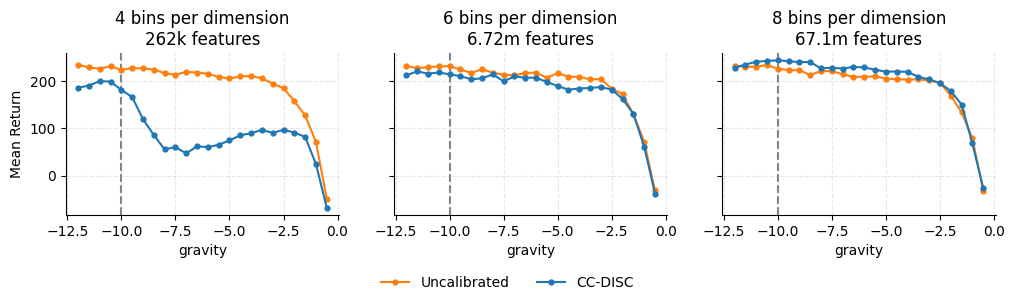

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

grid_spaces = {'4': '262k', '6': '6.72m', '8': '67.1m'}

for ix, n_bins in enumerate(['4', '6', '8']):
    plot_df = ll_scale_df[ll_scale_df['agent_type'] == n_bins].copy()
    plot_df = plot_df.set_index('gravity')[['returns_noconf', 'returns_conf']]
    ax = axes[ix]
    plot_df.plot(marker="o", ax=ax, legend=False, color=cmap, markersize=3.5)
    ax.axvline(scale_info.nominal_val, linestyle="--", color="k", zorder=0, alpha=0.5)
    despine(ax)
    ax.grid(alpha=0.3, linestyle="--")
    n_features = grid_spaces[n_bins]
    ax.set_title(f'{n_bins} bins per dimension\n{n_features} features')

axes[0].set_ylabel('Mean Return')

handles, labels = [], []
h, l = ax.get_legend_handles_labels()
l = [label_names[lab] for lab in l]
for hi, li in zip(h, l):
    if li not in labels:
        handles.append(hi)
        labels.append(li)

# room for the legend under the figure
fig.subplots_adjust(bottom=0.28, top=0.82)

# single legend below the figure laid out as a row
fig.legend(handles, labels, loc="lower center", ncol=len(labels), frameon=False)
plt.savefig(output_dir / 'robustness_experiments' / 'll_disc_scaling.pdf', bbox_inches='tight')

plt.show()

## Test-time

In [ ]:
acrobot_tt_info = deepcopy(acrobot_info)
acrobot_info.agent_result_names = {
    "dqn_ccnn_nofalloff": "normal",
    "tt_eta0-01_td": "testtime",
}

In [ ]:
tt_acro_df = load_dataframes(acrobot_info)
tt_acro_df['agent_type'] = 'ignore'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alexinch/Desktop/noodling/msc_thesis/results/acrobot/tt_eta0-01_mc/robustness_experiment.pkl'

In [ ]:
tt_cols = ['returns_noconf', 'returns_conf', 'returns_tta']

df = filter_df(tt_acro_df, acrobot_tt_info, aggfunc={c: 'mean' for c in tt_cols}).reset_index()
df = df.drop(columns='agent_type')

tt_acro_ratios = compute_ratios(df, acrobot_tt_info, 'returns_tta')
conf_acro_ratios = compute_ratios(df, acrobot_tt_info, 'returns_conf')
ratio_dict = {'CC-Disc': conf_acro_ratios, 'CC-Disc (test-time)': tt_acro_ratios}

ratio_score, ratio_cis = rly.get_interval_estimates(
    ratio_dict, iqm, reps=50_000
)
param_vals = df[acrobot_tt_info.param].unique()

CC-Disc Mean Improvement: 0.996x (0.982x - 1.009x)
CC-Disc (test-time) Mean Improvement: 1.000x (0.794x - 1.037x)


/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_54995/845011514.py:56: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28)


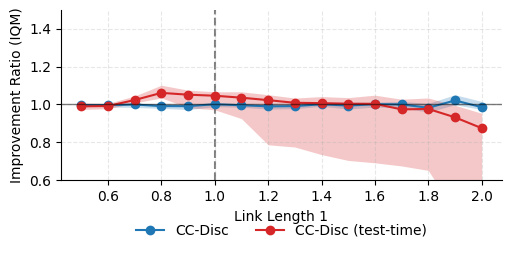

In [ ]:
plot_improvement_curve(
    xs=param_vals,
    ratio_score=ratio_score,
    ratio_cis=ratio_cis,
    title='',
    xlabel='Link Length 1',
    config=acrobot_tt_info,
    legend_title='',
    plotname='acro_tt',
    ylim=(0.6, 1.5),
    figsize=(5, 2.5)
)

In [ ]:
cartpole_tt_info = deepcopy(cartpole_info)
cartpole_tt_info.agent_result_names = {
    'alpha_exp_0-01': 'normal',
    'tt_eta0-01_td': 'testtime'
}

tt_cart_df = load_dataframes(cartpole_tt_info)
tt_cart_df['agent_type'] = 'ignore'

/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_54995/1560126169.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs)


In [154]:
df = filter_df(tt_cart_df, cartpole_tt_info, aggfunc={c: 'mean' for c in tt_cols}).reset_index()
df = df.drop(columns='agent_type')

tt_cart_ratios = compute_ratios(df, cartpole_tt_info, 'returns_tta')
conf_cart_ratios = compute_ratios(df, cartpole_tt_info, 'returns_conf')
ratio_dict = {'CC-Disc': conf_cart_ratios, 'CC-Disc (test-time)': tt_cart_ratios}

ratio_score, ratio_cis = rly.get_interval_estimates(
    ratio_dict, iqm, reps=50_000
)
param_vals = df[cartpole_tt_info.param].unique()

NameError: name 'tt_cart_df' is not defined

CC-Disc Mean Improvement: 1.638x (1.235x - 2.475x)
CC-Disc (test-time) Mean Improvement: 1.687x (1.175x - 2.607x)


/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_54995/845011514.py:56: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28)


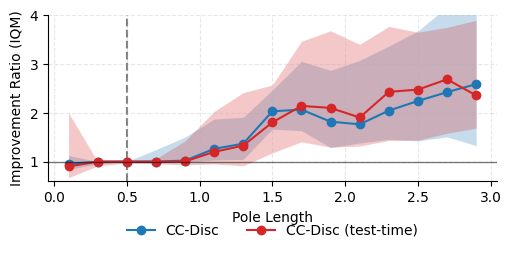

In [ ]:
plot_improvement_curve(
    xs=param_vals,
    ratio_score=ratio_score,
    ratio_cis=ratio_cis,
    title='',
    xlabel='Pole Length',
    config=cartpole_tt_info,
    legend_title='',
    plotname='cart_tt',
    ylim=(0.6, 4.0),
    figsize=(5, 2.5)
)

## Discretisation Comparison

In [187]:
cart_cfg = deepcopy(cartpole_info)
cart_data = pd.read_pickle(results_dir / cart_cfg.filename / 'discretisers' / 'discretisation_experiment.pkl')

acro_cfg = deepcopy(acrobot_info)
acro_cfg.agent_result_names = {'dqn_ccnn_nofalloff': 'DQN'}
acro_data = pd.read_pickle(results_dir / acro_cfg.filename / 'discretisers' / 'discretisation_experiment.pkl')

mcar_cfg = deepcopy(mountaincar_info)
mcar_data = pd.read_pickle(results_dir / mcar_cfg.filename / 'discretisers' / 'discretisation_experiment.pkl')

In [188]:
cfg = acro_cfg
data = acro_data

disc_types = [
    "Grid[4]",
    "Grid[6]",
    "Tile[4x2]",
    "Tile[4x4]",
    "Tile[6x2]",
    "Tile[6x4]",
    "Tile[8x2]",
    "Tree[d=4,l=1,med]",
    "Tree[d=6,l=1,med]",
    "Tree[d=6,l=5,imp]",
    "Tree[d=8,l=1,med]",
    "Tree[d=8,l=10,imp]",
]

def load_disc_data(cfg: EnvInfo, data: dict):
    df_rows = []

    for res in data:
        seed = int(res["seed"])
        all_exp_data = res["results"]
        for exp in all_exp_data:
            param_val = round(exp[cfg.param], 5)
            for disc_type in disc_types:
                type_data = exp[disc_type]
                for ix, ep_reward in enumerate(type_data):
                    df_row = {'seed': seed, cfg.param: param_val, 'returns_conf': ep_reward, 'agent_type': disc_type, 'run': ix}
                    df_rows.append(df_row)
    
    return pd.DataFrame(df_rows)

In [189]:
cart_df = load_disc_data(cart_cfg, cart_data)
acro_df = load_disc_data(acro_cfg, acro_data)
mcar_df = load_disc_data(mcar_cfg, mcar_data)
# cart_df = filter_df(cart_df, cart_cfg, aggfunc={'returns_conf': 'mean'}).reset_index()
# acro_df = filter_df(acro_df, acro_cfg, aggfunc={'returns_conf': 'mean'}).reset_index()
# mcar_df = filter_df(mcar_df, mcar_cfg, aggfunc={'returns_conf': 'mean'}).reset_index()

In [190]:
def get_disc_stats(cfg: EnvInfo, df: pd.DataFrame, normal_agent_type: str = 'DQN'):
    # need to 
    nm_df = load_dataframes(cfg)
    nm_df = nm_df[nm_df["agent_type"] == normal_agent_type].copy()
    nm_df["agent_type"] = "DQN"
    nm_df = nm_df.drop(columns=["agent_type", "returns_conf", "returns_ccnn"])
    df = df.merge(nm_df, on=['seed', cfg.param, 'run'])

    df = filter_df(df, cfg, aggfunc={'returns_conf': 'mean', 'returns_noconf': 'mean'}).reset_index()

    ratio_dict = {}
    param_vals = df[cfg.param].unique()
    for agent_type in disc_types:
        agent_df = df[df['agent_type'] == agent_type].copy()

        ratios = compute_ratios(agent_df, cfg, 'returns_conf')
        ratio_dict[agent_type] = ratios

    ratio_score, ratio_cis = rly.get_interval_estimates(
        ratio_dict, iqm, reps=50_000
    )
    return ratio_score, ratio_cis, param_vals

In [191]:
cart_score, cart_cis, _ = get_disc_stats(cart_cfg, cart_df, 'DQN-Disc')
mcar_score, mcar_cis, _ = get_disc_stats(mcar_cfg, mcar_df, 'DQN-Disc')
acro_score, acro_cis, _ = get_disc_stats(acro_cfg, acro_df, 'DQN')

In [211]:
cart_cis['Grid[4]'].mean(axis=1) * 100 - 100

array([ 27.31598416, 223.58259138])

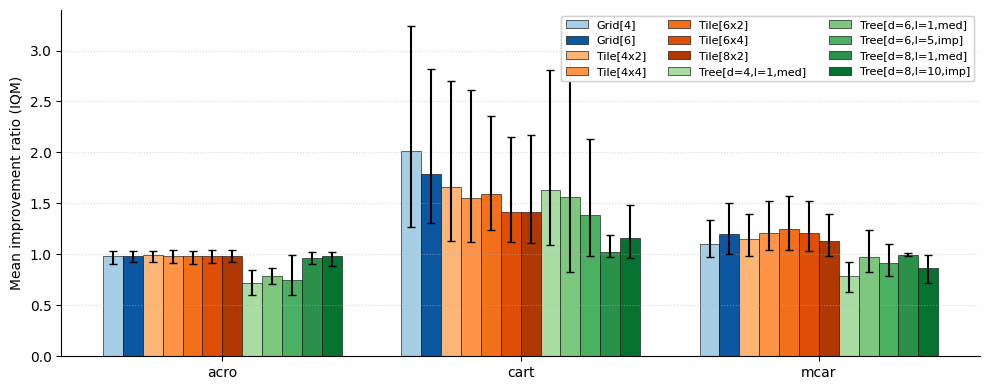

In [ ]:
import matplotlib as mpl

# --- Build adaptive colors for disc_types ------------------------------------
def disc_family(name: str) -> str:
    return name.split('[', 1)[0]  # "Grid[4]" -> "Grid"

# Choose distinct base colormaps for families
FAMILY_CMAPS = {
    "Grid": plt.cm.Blues,
    "Tile": plt.cm.Oranges,
    "Tree": plt.cm.Greens,
}

# Group items by family (preserves the order in disc_types)
family_items = {}
for d in disc_types:
    fam = disc_family(d)
    family_items.setdefault(fam, []).append(d)

# Generate evenly spaced shades, avoid extremes for contrast
item_colors = {}
for fam, items_f in family_items.items():
    cmap = FAMILY_CMAPS.get(fam, plt.cm.Greys)
    n = len(items_f)
    if n == 1:
        vals = [0.6]  # mid shade
    else:
        vals = np.linspace(0.35, 0.85, n)  # good spread
    for i, d in enumerate(items_f):
        item_colors[d] = cmap(vals[i])

# One group per environment
envs = [
    ("acro", acro_score, acro_cis),
    ("cart", cart_score, cart_cis),
    ("mcar", mcar_score, mcar_cis),
]

x = np.arange(len(envs))
w = 0.8 / len(disc_types)  # per-item bar width inside each env group

fig, ax = plt.subplots(figsize=(10, 4))

for j, item in enumerate(disc_types):
    means = []
    yerr_lo, yerr_hi = [], []
    for env, scores, cis in envs:
        mu = float(np.mean(scores[item]))
        lo = float(np.mean(cis[item][0]))  # mean lower bound
        hi = float(np.mean(cis[item][1]))  # mean upper bound
        means.append(mu)
        yerr_lo.append(max(0.0, mu - lo))
        yerr_hi.append(max(0.0, hi - mu))

    offset = (j - (len(disc_types) - 1) / 2) * w
    ax.bar(
        x + offset,
        means,
        width=w,
        label=item,
        yerr=np.vstack([yerr_lo, yerr_hi]),
        capsize=3,
        align="center",
        color=item_colors.get(item, "0.5"),
        edgecolor="black",
        linewidth=0.4,
    )

ax.set_xticks(x)
ax.set_xticklabels([lbl for lbl, *_ in envs])
ax.set_ylabel("Mean improvement ratio (IQM)")
# ax.set_title("Mean return ± CI per environment (bars = discretization items)")
despine(ax)
ax.grid(axis="y", linestyle=":", alpha=0.5)

# Legend 1: items (current handles)
leg_items = ax.legend(title="", ncol=3, fontsize=8)
ax.add_artist(leg_items)

fig.tight_layout()
plt.savefig(output_dir / 'robustness_experiments' / 'discretisation_comparison.pdf')
plt.show()